# Imports

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load Data

In [43]:
albums = pd.read_csv('albums_dw.csv', index_col=0)

In [44]:
albums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4402 entries, 0 to 4401
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ars_name          4402 non-null   object 
 1   rel_date          4402 non-null   int64  
 2   gens              4402 non-null   object 
 3   descs             4304 non-null   object 
 4   avg_rat           4402 non-null   float64
 5   num_rat           4402 non-null   int64  
 6   num_revs          4402 non-null   int64  
 7   album             4402 non-null   object 
 8   acousticness      4402 non-null   float64
 9   danceability      4402 non-null   float64
 10  energy            4402 non-null   float64
 11  instrumentalness  4402 non-null   float64
 12  liveness          4402 non-null   float64
 13  loudness          4402 non-null   float64
 14  speechiness       4402 non-null   float64
 15  tempo             4402 non-null   float64
 16  valence           4402 non-null   float64


# Exploratory Data Analysis

## Numerical Features

In [149]:
num_albums = albums.drop(columns=['ars_name', 'album', 'genre', 'gens', 'descs'])
num_albums.head()

,rel_date,avg_rat,num_rat,num_revs,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,time_signature
0,1997,4.23,70382,1531,0.135763,0.288083,0.565917,0.161053,0.159375,-9.102417,0.056308,115.450750,0.291733,268435.500000,4.000000
1,1975,4.29,48662,983,0.602800,0.373600,0.409800,0.363040,0.384940,-12.689400,0.039740,130.018800,0.259040,530512.000000,3.600000
2,1969,4.30,44943,870,0.297686,0.340625,0.370475,0.327265,0.149138,-14.873125,0.043463,118.920625,0.279400,507644.125000,3.875000
3,2000,4.21,58590,734,0.123219,0.601294,0.676706,0.000669,0.311412,-7.811941,0.268318,116.045059,0.398206,325379.529412,4.058824
4,2015,4.27,44206,379,0.322889,0.590750,0.707625,0.000011,0.318419,-5.802062,0.294175,103.444563,0.487187,296225.750000,3.812500


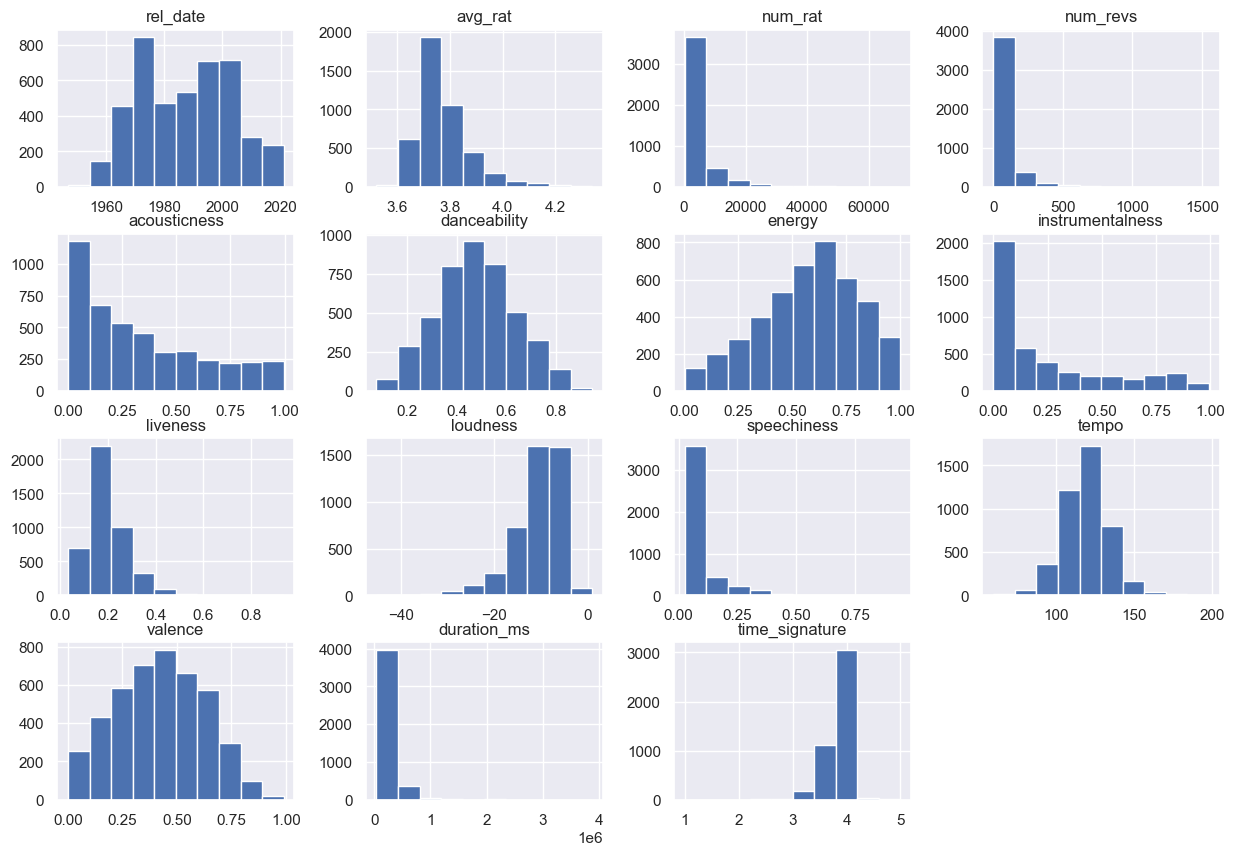

In [150]:
albums.hist(figsize=(15,10))
plt.show()

### Pearson Correlation Heatmap

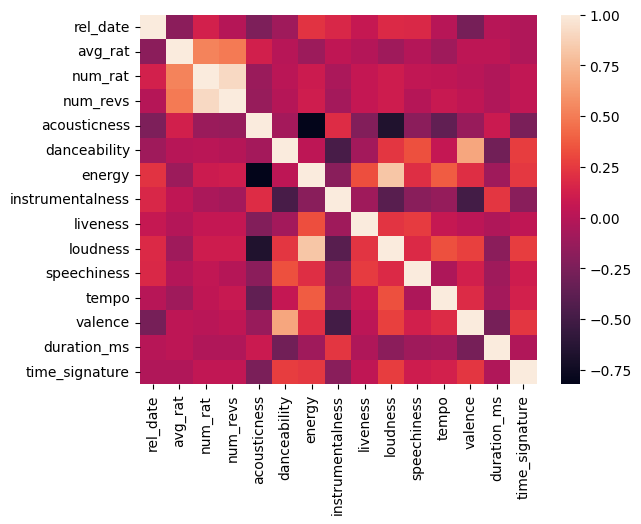

In [48]:
sns.heatmap(num_albums.corr())
plt.show()

### Loudness vs Energy

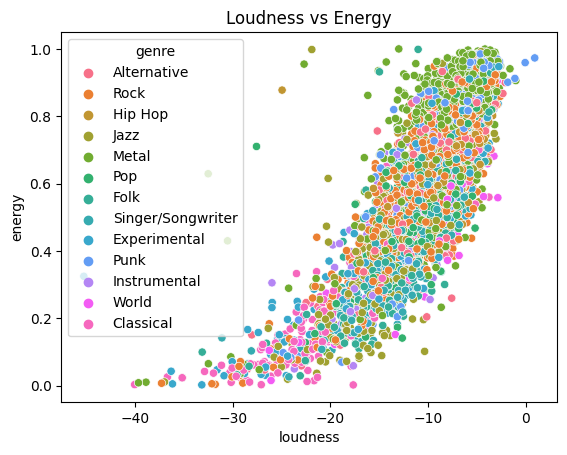

In [49]:
sns.scatterplot(x='loudness', y='energy', data=albums, hue='genre')
plt.title('Loudness vs Energy')
plt.show()

### Valence vs Danceability

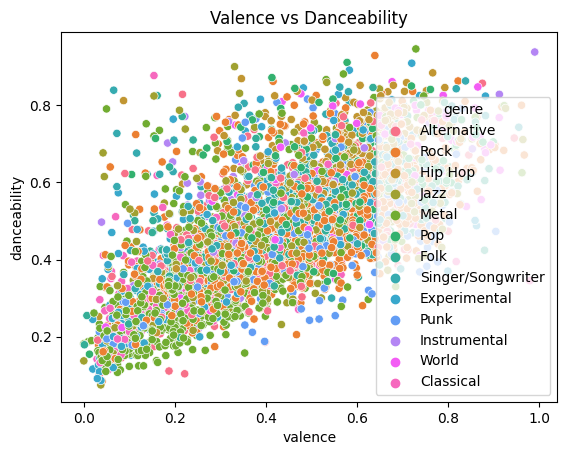

In [50]:
sns.scatterplot(x='valence', y='danceability', data=albums, hue='genre')
plt.title('Valence vs Danceability')
plt.show()

### Number of Ratings vs Number of Reviews

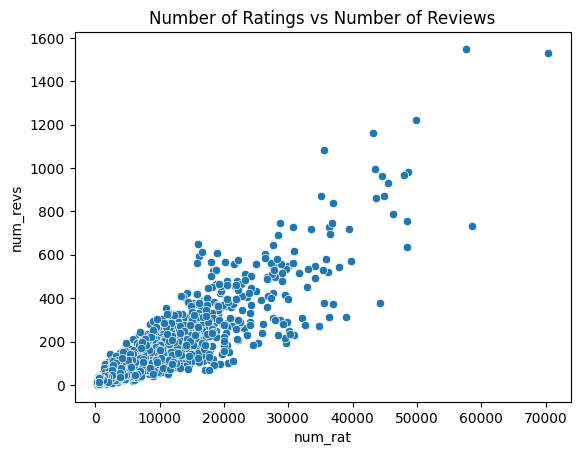

In [51]:
sns.scatterplot(x='num_rat', y='num_revs', data=albums)
plt.title('Number of Ratings vs Number of Reviews')
plt.show()

### Number of Ratings vs Average Rating

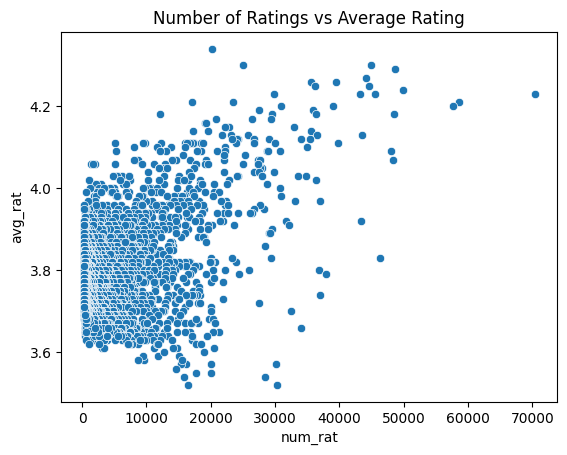

In [52]:
sns.scatterplot(x='num_rat', y='avg_rat', data=albums)
plt.title('Number of Ratings vs Average Rating')
plt.show()

### Entries by Genre

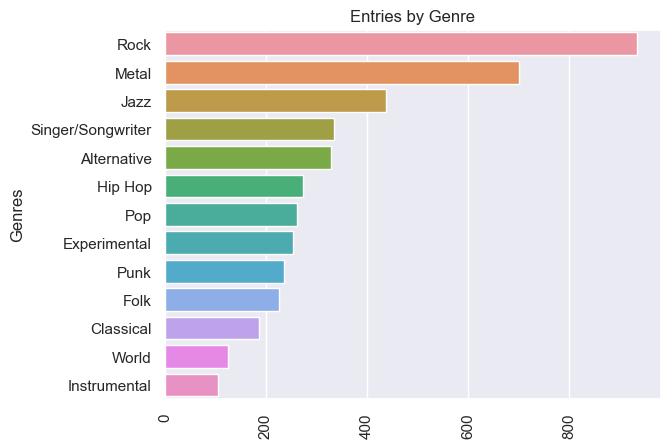

In [114]:
genres = albums.value_counts('genre')
sns.barplot(x=genres, y=genres.index, orient='h')
plt.xticks(rotation=90)
plt.ylabel('Genres')
plt.title('Entries by Genre')
plt.show()

### Average Rating by Genre

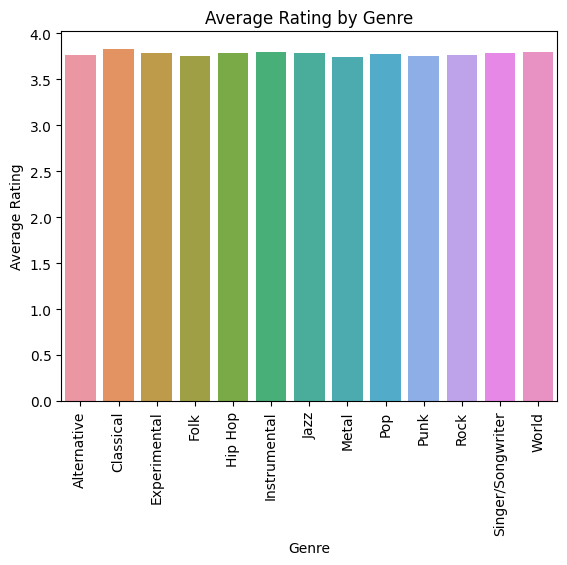

In [54]:
genre_ratings = albums.groupby('genre')['avg_rat'].mean().reset_index()

sns.barplot(x='genre', y='avg_rat', data=genre_ratings)
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.title('Average Rating by Genre')
plt.show()

### Albums per Year

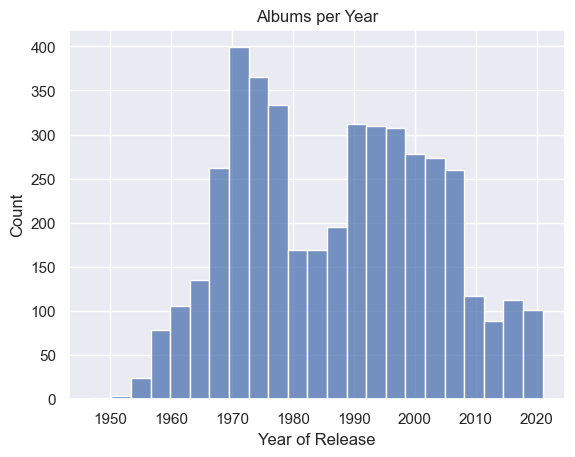

In [118]:
sns.histplot(albums['rel_date'])
plt.title('Albums per Year')
plt.xlabel('Year of Release')
plt.show()

### Number of Albums by Genre and Year

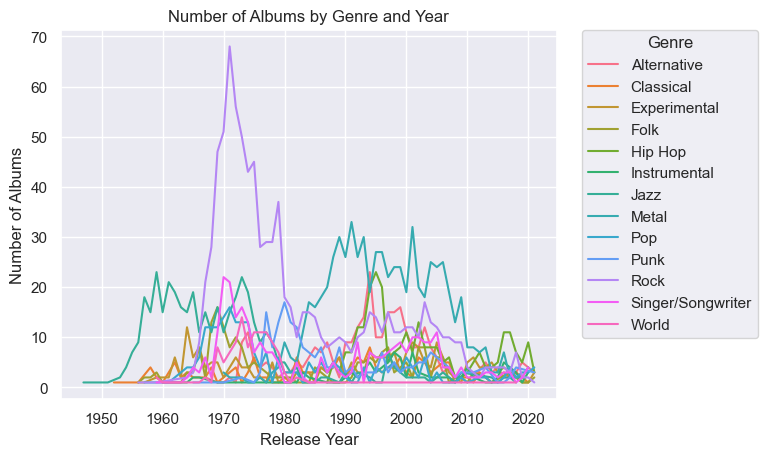

In [153]:
genre_year_counts = albums.groupby(['genre', 'rel_date']).size().reset_index(name='count')
sns.lineplot(x='rel_date', y='count', hue='genre', data=genre_year_counts)
plt.xlabel('Release Year')
plt.ylabel('Number of Albums')
plt.title('Number of Albums by Genre and Year')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## PCA

In [125]:
num_albums.head()

,rel_date,avg_rat,num_rat,num_revs,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,time_signature
0,1997,4.23,70382,1531,0.135763,0.288083,0.565917,0.161053,0.159375,-9.102417,0.056308,115.450750,0.291733,268435.500000,4.000000
1,1975,4.29,48662,983,0.602800,0.373600,0.409800,0.363040,0.384940,-12.689400,0.039740,130.018800,0.259040,530512.000000,3.600000
2,1969,4.30,44943,870,0.297686,0.340625,0.370475,0.327265,0.149138,-14.873125,0.043463,118.920625,0.279400,507644.125000,3.875000
3,2000,4.21,58590,734,0.123219,0.601294,0.676706,0.000669,0.311412,-7.811941,0.268318,116.045059,0.398206,325379.529412,4.058824
4,2015,4.27,44206,379,0.322889,0.590750,0.707625,0.000011,0.318419,-5.802062,0.294175,103.444563,0.487187,296225.750000,3.812500


In [126]:
y = list(albums['genre'])

In [127]:
x_scaled = StandardScaler().fit_transform(num_albums)

In [148]:
pca = PCA(n_components=8)

In [143]:
pca_features = pca.fit_transform(x_scaled)

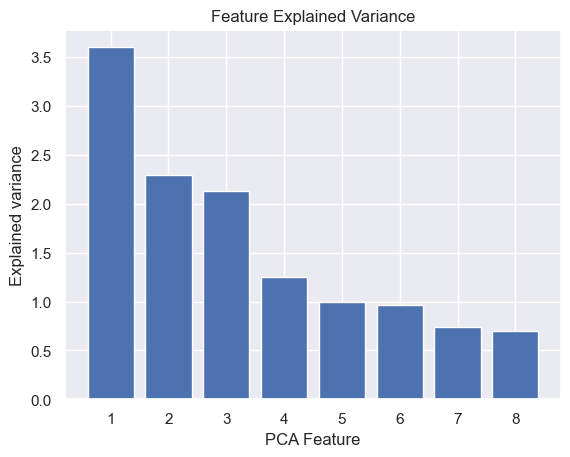

In [144]:
plt.bar(range(1,len(pca.explained_variance_)+1), pca.explained_variance_)

plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [145]:
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8'])
pca_df['genre'] = y

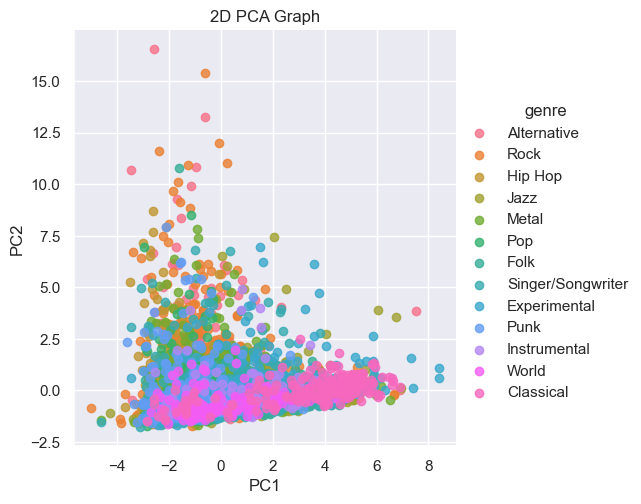

In [146]:
sns.set()
 
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df, 
    fit_reg=False, 
    legend=True,
    hue='genre'
    )
 
plt.title('2D PCA Graph')
plt.show()

# Natural Language Processing

## Descriptions

In [67]:
albums['descs'] = albums['descs'].fillna('')
desc_txt = ' '.join(albums['descs'].tolist())
desc_clean = desc_txt.replace(',','')

In [154]:
descs = word_tokenize(desc_clean)

In [166]:
descdist = FreqDist(descs)
descriptions = descdist.most_common(20)
descriptions = pd.DataFrame(descriptions, columns=['word', 'count'])

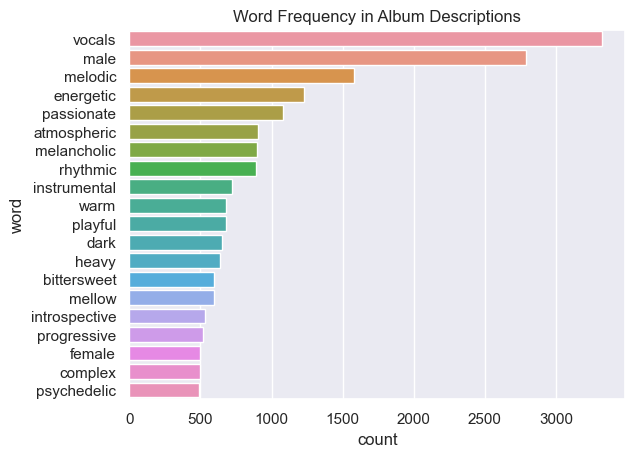

In [206]:
sns.barplot(data=descriptions, x='count', y='word', orient='h')
plt.title('Word Frequency in Album Descriptions')
plt.show()

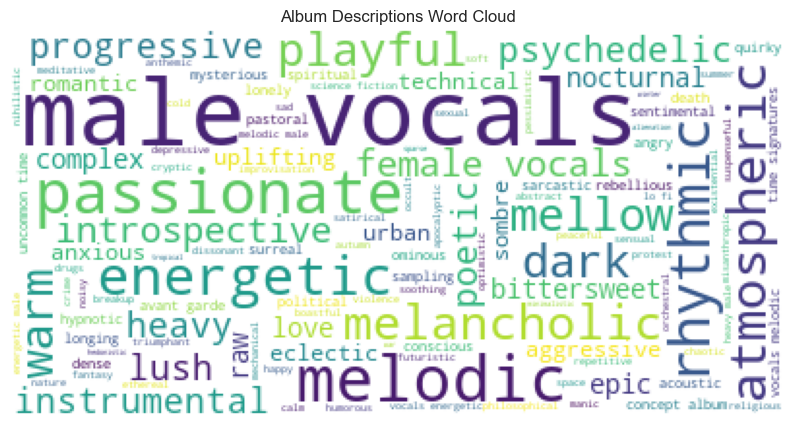

In [208]:
desccloud = WordCloud(background_color='white').generate(desc_clean)
plt.figure(figsize = (10, 10))
plt.imshow(desccloud)
plt.title('Album Descriptions Word Cloud')
plt.axis("off")
plt.show()

## Genres & Subgenres

In [184]:
gen_txt = ' '.join(albums['gens'].tolist())
gen_clean = gen_txt.replace(',','')

In [186]:
gens = word_tokenize(gen_clean)

In [199]:
gendist = FreqDist(gens)
genres = gendist.most_common(20)
genres = pd.DataFrame(genres, columns=['word', 'count'])

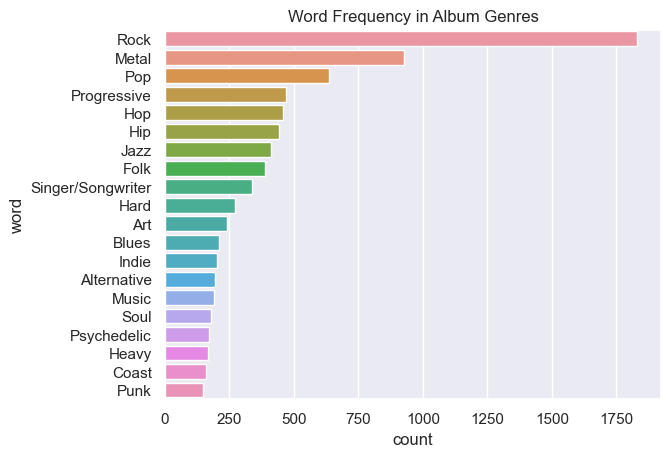

In [210]:
sns.barplot(data=genres, x='count', y='word', orient='h')
plt.title('Word Frequency in Album Genres')
plt.show()

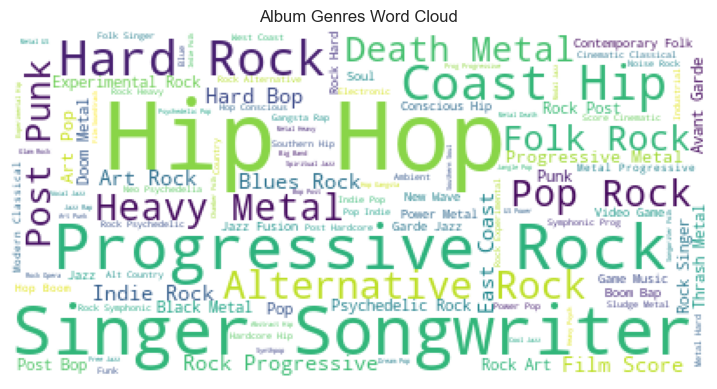

In [211]:
gencloud = WordCloud(background_color='white').generate(gen_clean)
plt.figure(figsize = (9, 9))
plt.imshow(gencloud)
plt.axis("off")
plt.title('Album Genres Word Cloud')
plt.show()

So far the most effective clustering feature seems to be the album descriptions and subgenre using NLP.

# Export Data

In [107]:
albums.to_csv('eda_albums.csv')